In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'data/philly_restaurant_photos.json'
data = pd.read_json(url, lines=True)
data.head()

,photo_id,business_id,caption,label
0,Le9rMdT8YFlvqr431LctIQ,BELS5YkYjDFkpbM2FuDdaA,Fried Chick'un Sandwich,food
1,zNzVcwnSJ4kvjFnANIsIRg,tw_PmFjjCyg0t8Ek_kQz0Q,,food
2,J1rqVl8pAoMJtPfGA2HV9w,jkGQQ4_LgJx3hwPtCFkzbQ,,outside
3,56xUu0i5oOBj9GdZqIg9_w,WMkiheTT-8kRslImVLWMVw,View from outside.,outside
4,GZpflvLA8AvQ6zi8aerdHg,t6g6Lj8WzjIXXucCl9jdTQ,Front seating area,inside


In [7]:
data.columns

Index(['photo_id', 'business_id', 'caption', 'label'], dtype='object')

In [8]:
data['label'].unique()

array(['food', 'outside', 'inside', 'drink', 'menu'], dtype=object)

In [9]:
data['label'].value_counts()

label
food       12935
inside      6180
outside     1732
drink       1227
menu         221
Name: count, dtype: int64

In [10]:
print(data['business_id'].nunique())
print(data['photo_id'].nunique())

3299
22295


In [11]:
data.groupby('business_id').size().describe()

count    3299.000000
mean        6.758109
std        11.732657
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       201.000000
dtype: float64

Grâce à cette première exploration on voit que :
- Prendre 3-5 photos par business est cohérent (médiane)
- Chaque photo a un label (food, drink, outside, inside, menu) qui peut nous aider dans le choix des photos pertinentes


### Exploitation du fichier photo.json pour un premier clustering

In [12]:
data['n_photos_total'] = data.groupby('business_id')['photo_id'].transform('count')
data['log_n_photos_total'] = np.log1p(data['n_photos_total'])
data.head()

,photo_id,business_id,caption,label,n_photos_total,log_n_photos_total
0,Le9rMdT8YFlvqr431LctIQ,BELS5YkYjDFkpbM2FuDdaA,Fried Chick'un Sandwich,food,3,1.386294
1,zNzVcwnSJ4kvjFnANIsIRg,tw_PmFjjCyg0t8Ek_kQz0Q,,food,9,2.302585
2,J1rqVl8pAoMJtPfGA2HV9w,jkGQQ4_LgJx3hwPtCFkzbQ,,outside,41,3.737670
3,56xUu0i5oOBj9GdZqIg9_w,WMkiheTT-8kRslImVLWMVw,View from outside.,outside,15,2.772589
4,GZpflvLA8AvQ6zi8aerdHg,t6g6Lj8WzjIXXucCl9jdTQ,Front seating area,inside,19,2.995732


In [13]:
data['share_food'] = data.groupby('business_id')['label'].transform(lambda x: (x == 'food').sum() / len(x))
data['share_inside'] = data.groupby('business_id')['label'].transform(lambda x: (x == 'inside').sum() / len(x))
data['share_outside'] = data.groupby('business_id')['label'].transform(lambda x: (x == 'outside').sum() / len(x))
data['share_menu'] = data.groupby('business_id')['label'].transform(lambda x: (x == 'menu').sum() / len(x))
data['share_drink'] = data.groupby('business_id')['label'].transform(lambda x: (x == 'drink').sum() / len(x))
data.head()

,photo_id,business_id,caption,label,n_photos_total,log_n_photos_total,share_food,share_inside,share_outside,share_menu,share_drink
0,Le9rMdT8YFlvqr431LctIQ,BELS5YkYjDFkpbM2FuDdaA,Fried Chick'un Sandwich,food,3,1.386294,0.666667,0.333333,0.000000,0.000000,0.000000
1,zNzVcwnSJ4kvjFnANIsIRg,tw_PmFjjCyg0t8Ek_kQz0Q,,food,9,2.302585,1.000000,0.000000,0.000000,0.000000,0.000000
2,J1rqVl8pAoMJtPfGA2HV9w,jkGQQ4_LgJx3hwPtCFkzbQ,,outside,41,3.737670,0.585366,0.292683,0.048780,0.000000,0.073171
3,56xUu0i5oOBj9GdZqIg9_w,WMkiheTT-8kRslImVLWMVw,View from outside.,outside,15,2.772589,0.400000,0.333333,0.133333,0.000000,0.133333
4,GZpflvLA8AvQ6zi8aerdHg,t6g6Lj8WzjIXXucCl9jdTQ,Front seating area,inside,19,2.995732,0.578947,0.157895,0.105263,0.105263,0.052632


In [14]:
data["has_caption"] = data["caption"].str.strip().ne("")

In [15]:
share_cols = ["share_food", "share_inside", "share_outside", "share_drink", "share_menu"]

p = data[share_cols].values      
print(type(p))

<class 'numpy.ndarray'>


In [20]:
share_cols = ["share_food", "share_inside", "share_outside", "share_drink", "share_menu"]

p = data[share_cols].values
data['entropy_photos'] = -np.sum(np.where(p > 0, p * np.log(p), 0), axis=1)

/var/folders/kz/jrt48myn5lv2h550w8pl7qvm0000gn/T/ipykernel_78742/3281240494.py:4: RuntimeWarning: divide by zero encountered in log
  data['entropy_photos'] = -np.sum(np.where(p > 0, p * np.log(p), 0), axis=1)
/var/folders/kz/jrt48myn5lv2h550w8pl7qvm0000gn/T/ipykernel_78742/3281240494.py:4: RuntimeWarning: invalid value encountered in multiply
  data['entropy_photos'] = -np.sum(np.where(p > 0, p * np.log(p), 0), axis=1)


In [21]:
data['proportion_captioned_photos'] = data.groupby('business_id')['has_caption'].transform('mean')

In [22]:
data_business = data.groupby('business_id').first().reset_index()
data_business.head()

,business_id,photo_id,caption,label,n_photos_total,log_n_photos_total,share_food,share_inside,share_outside,share_menu,share_drink,has_caption,entropy_photos,proportion_captioned_photos
0,-0M0b-XhtFagyLmsBtOe8w,1brLBjW5JznRUNdX7FItvQ,"Art Fischman plays Thursdays, photo by Julia B...",inside,1,0.693147,0.000000,1.000000,0.000000,0.0,0.000000,True,-0.000000,1.000000
1,-0TffRSXXIlBYVbb5AwfTg,yuiN7lIdU68tzK_kBE7C-w,Chole Bhature ($10),food,52,3.970292,0.711538,0.192308,0.019231,0.0,0.076923,True,0.832494,0.769231
2,-0eUa8TsXFFy0FCxHYmrjg,Nroz-phrBw1-TjaWIRBbMA,,food,1,0.693147,1.000000,0.000000,0.000000,0.0,0.000000,False,-0.000000,0.000000
3,-1B9pP_CrRBJYPICE5WbRA,_1OshZe5gGRaVngISHW14w,,inside,7,2.079442,0.571429,0.428571,0.000000,0.0,0.000000,False,0.682908,0.285714
4,-1b2kNOowsPrPpBOK4lNkQ,uJws1JbzW0TVQTDw6m6P5Q,Cayeye,food,5,1.791759,0.800000,0.200000,0.000000,0.0,0.000000,True,0.500402,0.800000


In [23]:
photo_features = ["log_n_photos_total", "share_food", "share_inside", "share_outside", "share_menu", "share_drink", "entropy_photos", "proportion_captioned_photos"]
X = data_business[photo_features].copy()

Standardisation des features

In [24]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

Déterminer le nombre optimal de clusters

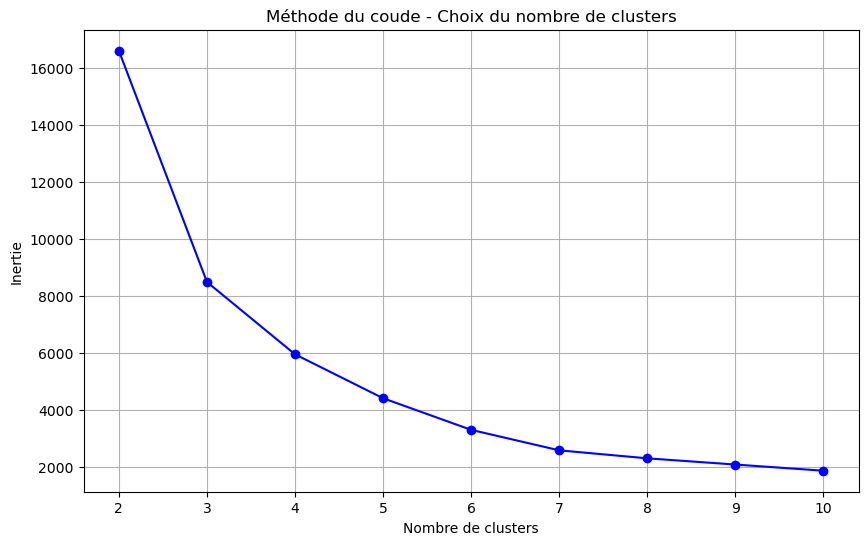

In [25]:
from sklearn.cluster import KMeans

# Tester différents nombres de clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualiser
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude - Choix du nombre de clusters')
plt.grid(True)
plt.show()

### N=5 clusters

In [26]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data_business['clusters'] = kmeans.fit_predict(X_scaled)
print(data_business['clusters'].value_counts().sort_index)
cluster_profiles = data_business.groupby('clusters')[photo_features].mean()
print(cluster_profiles.round(2))

<bound method Series.sort_index of clusters
2    1677
4     806
0     454
3     220
1     142
Name: count, dtype: int64>
          log_n_photos_total  share_food  share_inside  share_outside  \
clusters                                                                
0                       2.51        0.50          0.28           0.15   
1                       0.81        0.00          0.00           0.99   
2                       1.55        0.85          0.07           0.00   
3                       1.48        0.30          0.21           0.45   
4                       1.28        0.16          0.79           0.00   

          share_menu  share_drink  entropy_photos  proportion_captioned_photos  
clusters                                                                        
0               0.01         0.05            0.94                         0.52  
1               0.00         0.00            0.02                         0.43  
2               0.02         0.06          

Ces clusters basés uniquement sur les données des photos montrent que ce fichier seul ne suffit pas à identifier les profils de restaurant cherchés.  
Si on analyse :  
cluster 0 : commerces riches et diversifiés (bcp de photos, haute entropie donc diversifiés)  
cluster 1 : Terrasses? Très peu de photos (1.6), entropie quasi nulle et 99% outside  
cluster 2 : food-focused, nb photos moyen, 85% food.  
cluster 3 : nb photos moyen, food 30%, outside 45% et inside 21% donc commerces qui montrent autant ambiance que nourriture.  
cluster 4 : peu de photos (3.9), 79% inside 

### N=3 clusters

In [27]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data_business['clusters'] = kmeans.fit_predict(X_scaled)
print(data_business['clusters'].value_counts().sort_index)
cluster_profiles = data_business.groupby('clusters')[photo_features].mean()
print(cluster_profiles.round(2))


<bound method Series.sort_index of clusters
2    2782
0     358
1     159
Name: count, dtype: int64>
          log_n_photos_total  share_food  share_inside  share_outside  \
clusters                                                                
0                       1.74        0.37          0.24           0.34   
1                       0.91        0.01          0.02           0.96   
2                       1.60        0.61          0.31           0.01   

          share_menu  share_drink  entropy_photos  proportion_captioned_photos  
clusters                                                                        
0               0.01         0.03            0.85                         0.47  
1               0.00         0.01            0.09                         0.43  
2               0.01         0.05            0.35                         0.53  


Avec 3 clusters on voit différents clusters, un peu plus clair peut-être
Cluster 0 : équilibrés, expérience complète : nb photos moyen, haute entropie et mix équilibré food 37%, inside 24% et outside 34%
Cluster 1 : peu photos, entropie quasi nulle avec 96% outside
Cluster 2 : food-focused : faible entropie, 61% food et 31% inside